In [0]:
from IPython.display import display, clear_output
import math
import time

In [0]:
import numpy as np

In [3]:
print('MyGitColab')

!pwd
!ls

MyGitColab
/content
sample_data


### Случайные точки в кубе

In [0]:
n = 100
k = 10000
X = np.random.rand(n, 3)

### Расчёт потенциала с помощью цикла

In [0]:
%%time
if n <= 11000:
    L_for = 0
    L_for_inv = 0
    L_for_sq = 0
    for p in range(n):
        p_distance = 0
        for i in range(3):
            p_distance += X[p, i]**2
        p_distance = math.sqrt(p_distance)
        L_for_sq += k * (1 - p_distance)**2  # квадрат расстояния от поверхности сферы, умноженный на константу упругости
        for q in range(p + 1, n):
            if q != p:
                pq_distance = 0
                for i in range(3):
                    pq_distance += (X[p, i] - X[q, i]) ** 2
                pq_distance = math.sqrt(pq_distance)
                L_for_inv += 1 / pq_distance  # обратное расстояние между двумя точками
    L_for = (L_for_inv + L_for_sq) / n
    print('loss =', L_for)

loss = 825.9494743739165
CPU times: user 34.3 ms, sys: 0 ns, total: 34.3 ms
Wall time: 33.3 ms


### Расчёт потенциала по координатам точек с помощью numpy

In [0]:
%%time
S = X.dot(X.T)
pp_sq_dist = np.diag(S)
p_roll = pp_sq_dist.reshape(1, -1).repeat(n, axis=0)
q_roll = pp_sq_dist.reshape(-1, 1).repeat(n, axis=1)
pq_sq_dist = p_roll + q_roll - 2 * S
pq_dist = np.sqrt(pq_sq_dist)
pp_dist = np.sqrt(pp_sq_dist)
surface_dist_sq = (pp_dist - np.ones(n)) ** 2
rec_pq_dist = 1 / (pq_dist + np.eye(n)) - np.eye(n)
L_np_rec = rec_pq_dist.sum() / 2
L_np_surf = k * surface_dist_sq.sum()
L_np = (L_np_rec  + L_np_surf) / n
print('loss =', L_np)

loss = 825.9494743739164
CPU times: user 6.71 ms, sys: 0 ns, total: 6.71 ms
Wall time: 2.05 ms


### Расчёт потенциала по координатам с помощью pytorch

In [0]:
import torch

In [0]:
%%time
pt_x = torch.from_numpy(X) # pt_x - объект класса tensor из библиотеки pytorch
pt_S = pt_x.mm(pt_x.transpose(0, 1))  # mm - matrix multiplication
pt_pp_sq_dist = pt_S.diag()
pt_p_roll = pt_pp_sq_dist.repeat(n, 1)
pt_q_roll = pt_pp_sq_dist.reshape(-1, 1).repeat(1, n)
pt_pq_sq_dist = pt_p_roll + pt_q_roll - 2 * pt_S
pt_pq_dist = pt_pq_sq_dist.sqrt()
pt_pp_dist = pt_pp_sq_dist.sqrt()
pt_surface_dist_sq = (pt_pp_dist - torch.ones(n, dtype=torch.float64)) ** 2
pt_rec_pq_dist = 1/ (pt_pq_dist + torch.eye(n, dtype=torch.float64)) - torch.eye(n, dtype=torch.float64)
L_pt = (pt_rec_pq_dist.sum() / 2 + k * pt_surface_dist_sq.sum()) / n
print('loss =', float(L_pt))

loss = 825.9494743739161
CPU times: user 1.08 ms, sys: 555 µs, total: 1.63 ms
Wall time: 1.09 ms


### Расчёт потенциала по координатам с помощью tensorflow

In [0]:
import tensorflow as tf

In [0]:
tf_x = tf.placeholder(name='x', dtype=tf.float64)
tf_S = tf.matmul(tf_x, tf.transpose(tf_x))
tf_pp_sq_dist = tf.diag_part(tf_S)
tf_p_roll = tf.tile(tf.reshape(tf_pp_sq_dist, (1, -1)), (n, 1))
tf_q_roll = tf.tile(tf.reshape(tf_pp_sq_dist, (-1, 1)), (1, n))
tf_pq_sq_dist = tf_p_roll + tf_q_roll - 2 * tf_S
tf_pq_dist = tf.sqrt(tf_pq_sq_dist)
tf_pp_dist = tf.sqrt(tf_pp_sq_dist)
tf_surface_dist_sq = (tf_pp_dist - tf.ones(n, dtype=tf.float64)) ** 2
tf_rec_pq_dist = 1 / (tf_pq_dist + tf.eye(n, dtype=tf.float64)) - tf.eye(n, dtype=tf.float64)
L_tf = (tf.reduce_sum(tf_rec_pq_dist) / 2 + k * tf.reduce_sum(tf_surface_dist_sq)) / n

In [0]:
glob_init = tf.local_variables_initializer()

In [0]:
%%time
with tf.Session() as tf_s:
    glob_init.run()
    res, = tf_s.run([L_tf], feed_dict={tf_x: X})
    print(res)

825.9494743739161
CPU times: user 28.2 ms, sys: 0 ns, total: 28.2 ms
Wall time: 25.3 ms


### Рисование сфер

In [0]:
import vapory
from PIL import Image

In [0]:
def create_scene(moment, X):
    angle = 2 * math.pi * moment / 360
    r_camera = 10
    camera = vapory.Camera('location', [r_camera * math.cos(angle), 1.5, r_camera * math.sin(angle)], 'look_at', [0.0, 0.0, 0.0], 'angle', 30)
    light1 = vapory.LightSource([2, 4, -3], 'color', [1, 1, 1], 'shadowless')
    light2 = vapory.LightSource([2, 4, 3], 'color', [1, 1, 1], 'shadowless')
    plane = vapory.Plane([0, 1, 0], -2, vapory.Pigment('color', [1, 1, 1]))
    box = vapory.Box([0, 0, 0], [1, 1, 1], 
                     vapory.Pigment('Col_Glass_Clear'),
                     vapory.Finish('F_Glass9'),
                     vapory.Interior('I_Glass1'))
    spheres = [vapory.Sphere( [float(r[0]), float(r[1]), float(r[2])], 0.05, vapory.Texture(vapory.Pigment('color', [1, 1, 0]))) for r in X]
    return vapory.Scene(camera, objects=[light1, light2, plane, box] + spheres, included=['glass.inc'])

In [0]:
for t in range(0, 360, 4):    
    flnm = 'out_small/sphere_{:03}.png'.format(t // 4)
    scene = create_scene(t)
    scene.render(flnm, width=200, height=150)    
    clear_output()
    display(Image.open(flnm))

### Равномерное распределение с помощью pytorch

In [0]:
n = 5
k = 1000
import torch
torch_coords_np = np.random.rand(n, 3)

In [0]:
torch_coords_tensor = torch.from_numpy(torch_coords_np)

In [0]:
pt_X = torch.nn.Parameter(torch_coords_tensor)

In [0]:
def create_loss(pt_X):
    pt_xxt = pt_X.mm(pt_X.transpose(0, 1))
    pt_pp_sq_dist = pt_xxt.diag()
    pt_p_roll = pt_pp_sq_dist.repeat(n, 1)
    pt_q_roll = pt_pp_sq_dist.reshape(-1, 1).repeat(1, n)
    pt_pq_sq_dist = pt_p_roll + pt_q_roll - 2 * pt_xxt + torch.eye(n, dtype=torch.float64)
    pt_pq_dist = pt_pq_sq_dist.sqrt()
    pt_pp_dist = pt_pp_sq_dist.sqrt()
    pt_surface_dist_sq = (pt_pp_dist - torch.ones(n, dtype=torch.float64)) ** 2
    pt_rec_pq_dist = 1 / pt_pq_dist - torch.eye(n, dtype=torch.float64)
    pt_ans_00 = pt_rec_pq_dist.sum()
    pt_ans_01 = k * pt_surface_dist_sq.sum()
    pt_L = (pt_ans_00 / 2 + pt_ans_01) / n
    return pt_L

In [0]:
def create_loss_rake(pt_X):
    pt_xxt = pt_X.mm(pt_X.transpose(0, 1))
    pt_pp_sq_dist = pt_xxt.diag()
    pt_p_roll = pt_pp_sq_dist.repeat(n, 1)
    pt_q_roll = pt_pp_sq_dist.reshape(-1, 1).repeat(1, n)
    pt_pq_sq_dist = pt_p_roll + pt_q_roll - 2 * pt_xxt + torch.eye(n, dtype=torch.float64)
    pt_pq_dist = pt_pq_sq_dist.sqrt()
    pt_pp_dist = pt_pp_sq_dist.sqrt()
    pt_surface_dist_sq = (pt_pp_dist - torch.ones(n, dtype=torch.float64)) ** 2
    pt_rec_pq_dist = 1 / pt_pq_dist - torch.eye(n, dtype=torch.float64)
    pt_ans_00 = pt_rec_pq_dist.sum()
    pt_ans_01 = k * pt_surface_dist_sq.sum()
    pt_L = (pt_ans_00 / 2 + pt_ans_01) / n
    return pt_L

In [0]:
pt_X

Parameter containing:
tensor([[0.9002, 0.3357, 0.5194],
        [0.5875, 0.0893, 0.9451],
        [0.5208, 0.9648, 0.7678],
        [0.8150, 0.9722, 0.7367],
        [0.0661, 0.4521, 0.4817]], dtype=torch.float64, requires_grad=True)

In [0]:
L = create_loss_rake(pt_X)

In [0]:
L.backward()

In [0]:
pt_X.grad

tensor([[ 29.5873,  11.8047,  18.2031],
        [ 24.6431,   4.5842,  38.6982],
        [ 54.9100,  96.8913,  77.2333],
        [101.3414, 122.9962,  93.9065],
        [-12.4928, -91.3555, -97.1234]], dtype=torch.float64)

In [0]:
L

tensor(96.5209, dtype=torch.float64, grad_fn=<DivBackward0>)

In [0]:
pt_X.grad.zero_()

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)

In [0]:
opt = torch.optim.SGD([pt_X], lr=0.01, momentum=0.9)

! mkdir out_movie_00

tensor(226.1055, dtype=torch.float64, grad_fn=<DivBackward0>)

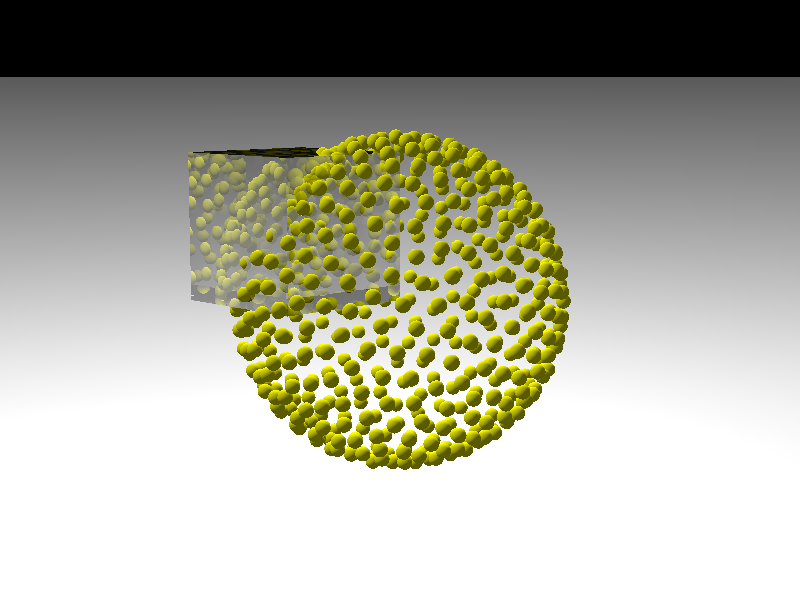

KeyboardInterrupt: 

In [0]:
for t in range(720):
    flnm = 'out_movie_00/sphere_{:04}.png'.format(t)
    opt.zero_grad()
    pt_L = create_loss(pt_X)
    pt_L.backward()
    scene = create_scene(t, pt_X)
    scene.render(flnm)
    opt.step()
    clear_output()
    display(pt_L, Image.open(flnm))

```ffmpeg -r 1/5 -i sphere_%04d.png -c:v libx264 -vf "fps=25,format=yuv420p" out_movie_00.mp4```

```ffmpeg -i images/%04.png -o liquid.avi```